In [8]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import polars as pl
import numpy as np


In [9]:
ds = xr.open_dataset(Path("data_original/spectra_coh_LES.nc"))

In [10]:
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB ...
    spectralDensity_vv  (radius, height, frequency) float64 1MB ...
    spectralDensity_ww  (radius, height, frequency) float64 1MB ...
    spectralDensity_uw  (radius, height, f

In [11]:
# Coordinates for spectra
radius_ds = np.array(ds['radius'])
height_ds = np.array(ds['height'])
freq_ds = np.array(ds['frequency'])

fUU_ds = np.array(ds['spectralDensity_uu'])
fVV_ds = np.array(ds['spectralDensity_vv'])
fWW_ds = np.array(ds['spectralDensity_ww'])
fUW_ds = np.array(ds['spectralDensity_uw'])
fUV_ds = np.array(ds['spectralDensity_uv'])
fVW_ds = np.array(ds['spectralDensity_vw'])


In [13]:
fUU_ds.shape

(1, 60, 3001)

In [14]:
# Grab a particular height
height = len(height_ds) // 2

# Get spectra at that height

freq_h = freq_ds.copy()
fUU_h = np.squeeze(fUU_ds[0, height, :])
fVV_h = np.squeeze(fVV_ds[0, height, :])
fWW_h = np.squeeze(fWW_ds[0, height, :])
fUW_h = np.squeeze(fUW_ds[0, height, :])
fUV_h = np.squeeze(fUV_ds[0, height, :])
fVW_h = np.squeeze(fVW_ds[0, height, :])


In [28]:
print(height_ds[height])

148.56202535609793


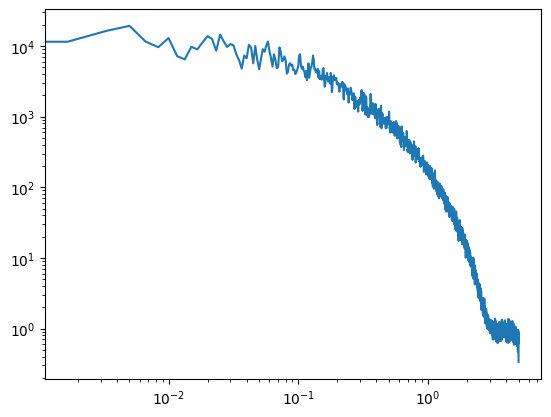

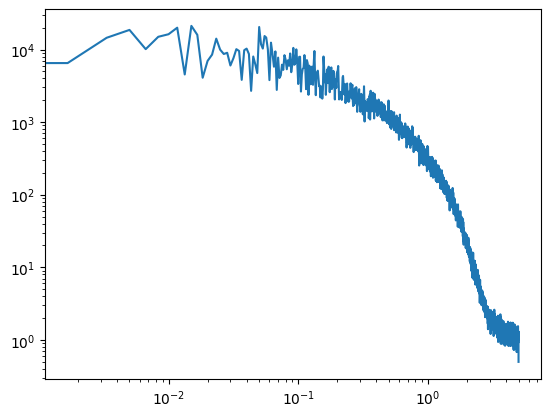

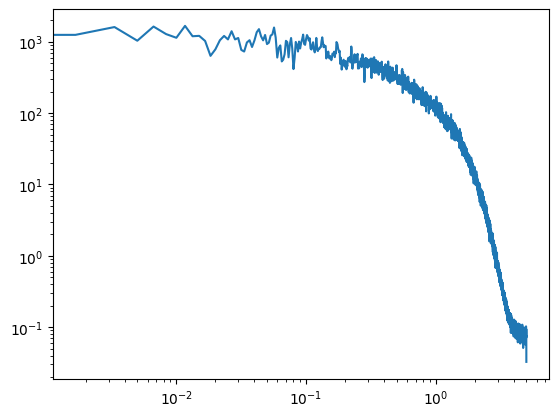

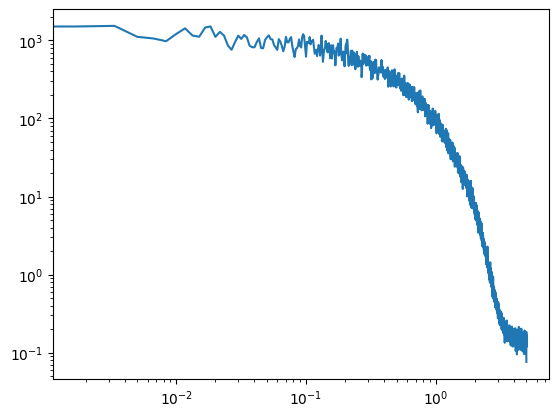

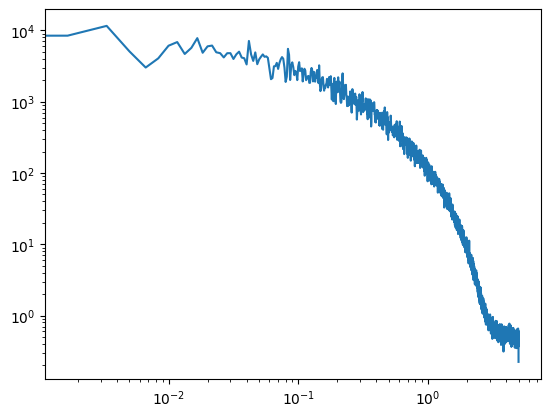

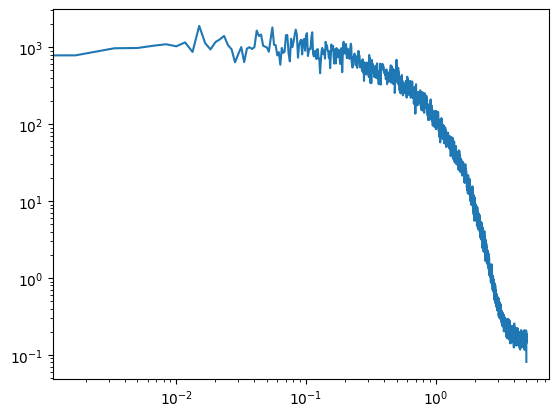

In [15]:
plt.loglog(freq_h, fUU_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fVV_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fWW_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fUW_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fUV_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fVW_h)
plt.show()





In [16]:
# NOTE: Copied from older data_clean.ipynb
def clean_spectra(
    frequency,
    uu,
    vv,
    ww,
    uw,
    vw,
    uv,
    threshold=1.0,
    buffer_points=10
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Clean all spectral components using a common cutoff point.
    
    Parameters
    ----------
    frequency : np.ndarray
        The frequency values (3001,)
    uu, vv, ww, uw : np.ndarray
        The spectral components (each 3001,)
    threshold : float, optional
        The threshold value below which to cut off (default: 1.0)
    buffer_points : int, optional
        Number of points to keep before the cutoff for smooth transition
        
    Returns
    -------
    cleaned_freq : np.ndarray
        The cleaned frequency array
    cleaned_uu, cleaned_vv, cleaned_ww, cleaned_uw : np.ndarray
        The cleaned spectral components
    """
    # Find where each component drops below threshold
    cutoff_idx_uu = np.where(uu < threshold)[0][0] if np.any(uu < threshold) else len(uu)
    cutoff_idx_vv = np.where(vv < threshold)[0][0] if np.any(vv < threshold) else len(vv)
    cutoff_idx_ww = np.where(ww < threshold)[0][0] if np.any(ww < threshold) else len(ww)
    
    # For uw (cross-spectrum), use absolute value since it can be negative
    cutoff_idx_uw = np.where(np.abs(uw) < threshold/10)[0][0] if np.any(np.abs(uw) < threshold/10) else len(uw)
    cutoff_idx_vw = np.where(np.abs(vw) < threshold/10)[0][0] if np.any(np.abs(vw) < threshold/10) else len(vw)
    cutoff_idx_uv = np.where(np.abs(uv) < threshold/10)[0][0] if np.any(np.abs(uv) < threshold/10) else len(uv)
    
    # Take the earliest cutoff point to ensure all spectra are valid
    cutoff_idx = min(
        cutoff_idx_uu,
        cutoff_idx_vv,
        cutoff_idx_ww,
        cutoff_idx_uw,
        cutoff_idx_vw,
        cutoff_idx_uv
    )
    
    # Add buffer
    final_idx = max(0, cutoff_idx - buffer_points)
    
    # Return cleaned arrays
    return (frequency[:final_idx],
            uu[:final_idx],
            vv[:final_idx],
            ww[:final_idx],
            uw[:final_idx],
            vw[:final_idx],
            uv[:final_idx])

In [17]:
cleaned_freq_spectra = clean_spectra(
    frequency=freq_h,
    uu=fUU_h,
    vv=fVV_h,
    ww=fWW_h,
    uw=fUW_h,
    vw=fVW_h,
    uv=fUV_h
)

In [18]:
cfreq_h = cleaned_freq_spectra[0]
cfUU_h = cleaned_freq_spectra[1]
cfVV_h = cleaned_freq_spectra[2]
cfWW_h = cleaned_freq_spectra[3]
cfUW_h = cleaned_freq_spectra[4]
cfVW_h = cleaned_freq_spectra[5]
cfUV_h = cleaned_freq_spectra[6]

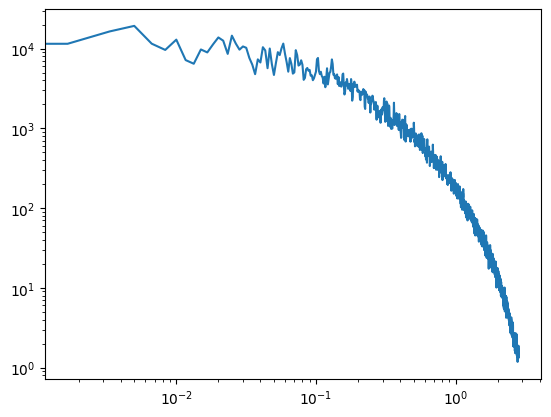

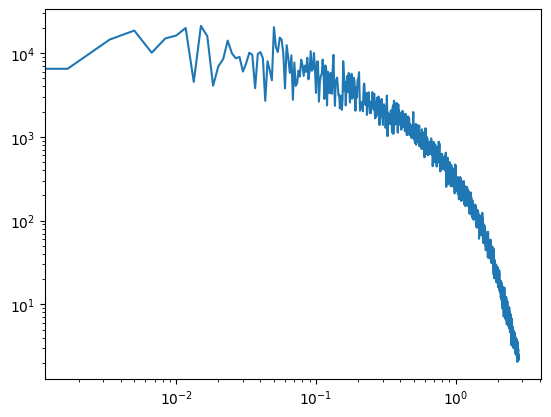

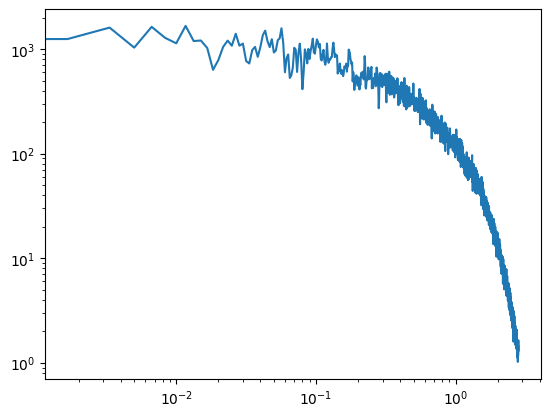

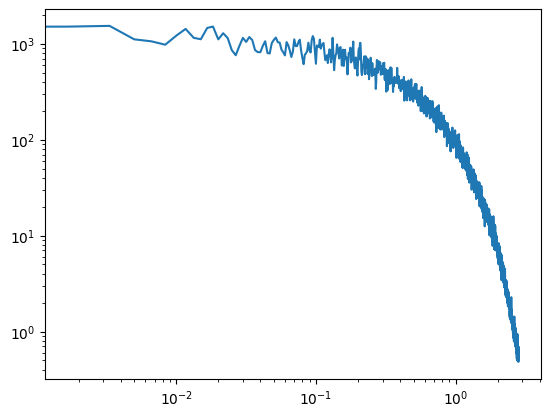

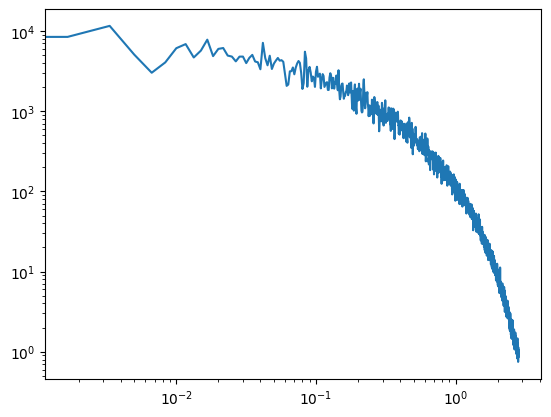

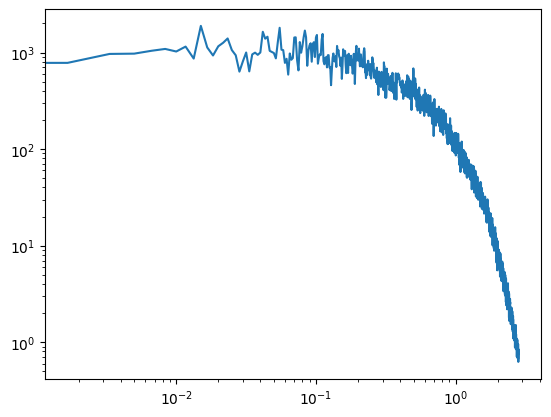

In [19]:
plt.loglog(cfreq_h, cfUU_h)
plt.show()
plt.figure()
plt.loglog(cfreq_h, cfVV_h)
plt.show()
plt.figure()
plt.loglog(cfreq_h, cfWW_h)
plt.show()
plt.figure()
plt.loglog(cfreq_h, cfUW_h)
plt.show()
plt.figure()
plt.loglog(cfreq_h, cfUV_h)
plt.show()
plt.figure()
plt.loglog(cfreq_h, cfVW_h)
plt.show()



In [20]:
weighted_uu = cfUU_h * cfreq_h
weighted_vv = cfVV_h * cfreq_h
weighted_ww = cfWW_h * cfreq_h
weighted_uw = cfUW_h * cfreq_h
weighted_vw = cfVW_h * cfreq_h
weighted_uv = cfUV_h * cfreq_h

In [ ]:
plt.loglog(cfreq_h, weighted_uu)
plt.show()
plt.figure()
plt.loglog(cfreq_h, weighted_vv)
plt.show()
plt.figure()
plt.loglog(cfreq_h, weighted_ww)
plt.show()
plt.figure()
plt.loglog(cfreq_h, weighted_uw)
plt.show()
plt.figure()
plt.loglog(cfreq_h, weighted_vw)
plt.show()
plt.figure()
plt.loglog(cfreq_h, weighted_uv)

In [21]:
def log_downsample(freq, data_columns, points_per_decade=20):
    """Downsample data with logarithmic spacing."""
    # Ensure all inputs are numpy arrays
    freq = np.array(freq)
    data_arrays = [np.array(col) for col in data_columns]
    
    # Filter out any zero or negative values in frequency
    positive_mask = freq > 0
    if not np.all(positive_mask):
        freq = freq[positive_mask]
        data_arrays = [col[positive_mask] for col in data_arrays]
        
    # Calculate frequency decades (log10 ranges)
    min_freq, max_freq = np.min(freq), np.max(freq)
    
    # Add a small epsilon to min_freq to prevent log10(0)
    min_freq = max(min_freq, 1e-10)
    
    min_decade, max_decade = np.log10(min_freq), np.log10(max_freq)
    num_decades = max_decade - min_decade
    
    # Ensure num_decades is positive
    if num_decades <= 0:
        num_decades = 1.0  # Default to at least one decade
    
    # Calculate total number of points to keep
    total_points = int(np.ceil(points_per_decade * num_decades))
    
    # Ensure we have at least 2 points
    total_points = max(total_points, 2)
    
    # Create logarithmically spaced frequency points
    log_spaced_freq = np.logspace(min_decade, max_decade, total_points)
    
    # Find indices of original data points closest to these log-spaced points
    downsampled_indices = []
    for target_freq in log_spaced_freq:
        idx = np.argmin(np.abs(freq - target_freq))
        if idx not in downsampled_indices:  # Avoid duplicates
            downsampled_indices.append(idx)
    
    # Sort indices
    downsampled_indices.sort()
    
    # Return downsampled frequency and data arrays
    downsampled_freq = freq[downsampled_indices]
    downsampled_data = [col[downsampled_indices] for col in data_arrays]
    
    return downsampled_freq, downsampled_data

downsampled_freq, downsampled_data = log_downsample(
    cfreq_h, 
    [weighted_uu, weighted_vv, weighted_ww, weighted_uw, weighted_vw, weighted_uv],
    points_per_decade=50  # Adjust this
)

In [22]:
downsampled_data_array = np.column_stack([downsampled_freq] + downsampled_data)

In [23]:
np.savetxt(
    'data_cleaned/log_downsampled_6component_spectra.dat',
    downsampled_data_array,
    delimiter=","
)

# Coherence Data

In [24]:
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB 2.215e+03 ......
    spectralDensity_vv  (radius, height, frequency) float64 1MB 534.9 ... 0.8316
    spectralDensity_ww  (radius, height, frequency) float64 1MB 0.01027 ... 0...
   

In [26]:
spatialSeparation_ds = np.array(ds['spatialSeparation'])
coh_freq_ds = np.array(ds['frequency_coh'])

coh_u_alongCross_ds = np.array(ds['coh_u_alongCross'])
coh_v_alongCross_ds = np.array(ds['coh_v_alongCross'])
coh_w_alongCross_ds = np.array(ds['coh_w_alongCross'])